<a href="https://colab.research.google.com/github/Pankaj-2003/Numerai_Models/blob/main/numerai_first_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numerapi numpy pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline

In [3]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()
all_datasets = napi.list_datasets()

In [4]:
dataset_versions = list(set([i.split("/")[0] for i in all_datasets]))
dataset_versions

['v4.3', 'v4.1', 'v4', 'v4.2']

In [5]:
dataset_version = "v4.3"
current_version_files = [i for i in all_datasets if i.startswith(dataset_version)]
current_version_files

['v4.3/features.json',
 'v4.3/live_benchmark_models.parquet',
 'v4.3/live_example_preds.csv',
 'v4.3/live_example_preds.parquet',
 'v4.3/live_int8.parquet',
 'v4.3/meta_model.parquet',
 'v4.3/train_benchmark_models.parquet',
 'v4.3/train_int8.parquet',
 'v4.3/validation_benchmark_models.parquet',
 'v4.3/validation_example_preds.csv',
 'v4.3/validation_example_preds.parquet',
 'v4.3/validation_int8.parquet']

In [6]:
import json
napi.download_dataset(f"{dataset_version}/features.json");
feature_metadata = json.load(open(f"{dataset_version}/features.json"))

v4.3/features.json: 1.12MB [00:00, 4.61MB/s]                           


In [7]:
for i in feature_metadata.keys():
  print(f'{i}: {len(feature_metadata[i])}')


feature_stats: 2376
feature_sets: 17
targets: 41


In [8]:
features = ["small","medium","all"]
for i in features:
  print(f"{i}:{len(feature_metadata['feature_sets'][i])}")

small:42
medium:705
all:2376


In [9]:
# loading dataset
import pandas as pd
feature_sets = feature_metadata["feature_sets"]["medium"]
napi.download_dataset(f"{dataset_version}/train_int8.parquet");
train = pd.read_parquet(f"{dataset_version}/train_int8.parquet",columns = ["era","target"] + feature_sets)
train = train[train["era"].isin(train["era"].unique()[::4])]

v4.3/train_int8.parquet: 2.09GB [01:28, 23.8MB/s]                            


In [10]:
# exploring eras(took just first 10 to get a idea)
train.groupby(["era"]).size()

era
0001    2072
0005    2406
0009    2370
0013    2427
0017    2527
        ... 
0557    4627
0561    4694
0565    4745
0569    4798
0573    4793
Length: 144, dtype: int64

<Axes: title={'center': 'No. of rows per era'}, xlabel='era'>

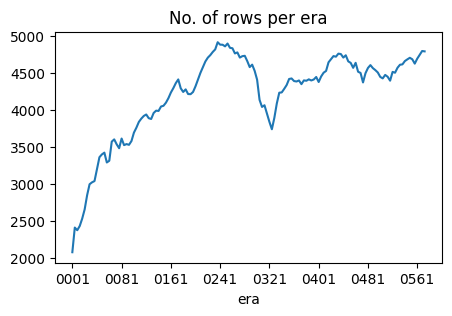

In [11]:
# no of rows per era
train.groupby('era').size().plot(title = "No. of rows per era",figsize = (5,3),xlabel = "era")

<Axes: title={'center': 'Target'}, ylabel='Frequency'>

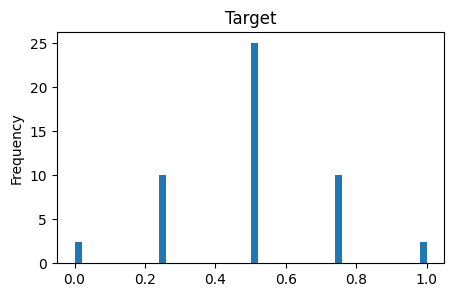

In [12]:
train["target"].plot(kind = 'hist', figsize = (5,3), bins = 50 , title = "Target",xlabel = "value", density = True)

<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

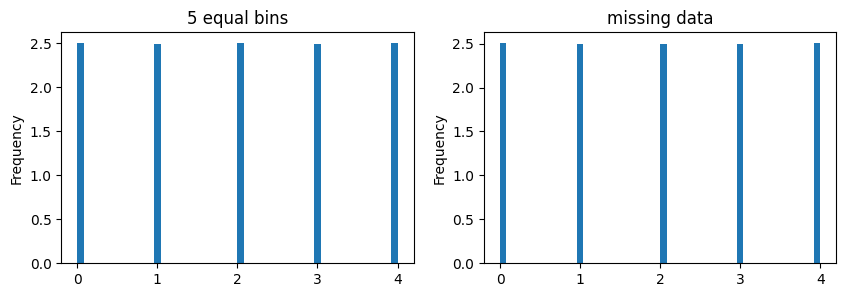

In [13]:
import matplotlib.pyplot as plt
fig ,(ax1 , ax2) = plt.subplots(1,2,figsize = (10,3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era  = train[train["era"] == train["era"].unique()[-1]]
last_era[train.columns[2]].plot(kind = 'hist', density = True , title = "5 equal bins", bins = 50,ax = ax1)
first_era[train.columns[2]].plot(kind = 'hist', title = "missing data", density = True, bins = 50, ax = ax2)

In [14]:
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators = 2000 , learning_rate = 0.01 , max_depth = 5, num_leaves = 2**5-1 , colsample_bytree = 0.1)
model.fit(train[feature_metadata["feature_sets"]["medium"]],train["target"]);

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 705
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [15]:
# downloading validation dataset
napi.download_dataset("v4.3/validation_int8.parquet")
validation = pd.read_parquet("v4.3/validation_int8.parquet", columns = ["era","data_type","target"]+ feature_metadata["feature_sets"]["medium"])

v4.3/validation_int8.parquet: 2.50GB [02:39, 15.7MB/s]                            


In [16]:
validation

,era,data_type,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,validation,0.75,0,0,1,0,3,1,4,...,1,1,1,2,3,0,3,0,2,0
n001e1318d5072ac,0575,validation,0.00,1,4,3,1,3,1,3,...,3,4,3,3,2,2,2,1,2,2
n002a9c5ab785cbb,0575,validation,0.50,2,0,1,1,2,4,3,...,2,4,2,4,3,1,1,1,0,1
n002ccf6d0e8c5ad,0575,validation,0.00,4,0,1,2,1,0,0,...,3,0,1,1,2,2,0,0,2,3
n0051ab821295c29,0575,validation,0.50,0,3,3,0,4,0,4,...,3,0,3,2,3,1,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffdb6e40e2f845c,1103,test,NaN,4,0,0,4,3,0,1,...,2,0,4,1,3,4,0,2,2,1
nffe7ab06ef8a5a5,1103,test,NaN,4,0,1,2,1,0,0,...,0,0,0,2,0,0,0,0,2,1
nffeddeb986175f9,1103,test,NaN,2,2,4,1,3,1,2,...,2,0,0,0,2,2,4,1,2,2


In [17]:
# selecting validation dataset out

validation = validation[validation["data_type"] == "validation"]

# downsampling to every fourth era to speed up evaluation
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

In [18]:
del validation["data_type"]

In [19]:
validation

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,0,1,0,3,1,4,0,...,1,1,1,2,3,0,3,0,2,0
n001e1318d5072ac,0575,0.00,1,4,3,1,3,1,3,4,...,3,4,3,3,2,2,2,1,2,2
n002a9c5ab785cbb,0575,0.50,2,0,1,1,2,4,3,4,...,2,4,2,4,3,1,1,1,0,1
n002ccf6d0e8c5ad,0575,0.00,4,0,1,2,1,0,0,3,...,3,0,1,1,2,2,0,0,2,3
n0051ab821295c29,0575,0.50,0,3,3,0,4,0,4,3,...,3,0,3,2,3,1,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffbac0ca31b666c,1095,0.50,4,1,4,1,0,3,0,2,...,4,3,4,4,1,4,0,1,0,4
nffbd52f4a0973ef,1095,0.50,1,2,1,0,4,4,3,4,...,2,4,4,4,4,4,4,3,4,0
nffd25d0a9b2e914,1095,0.75,3,3,1,0,0,3,0,2,...,0,3,0,3,2,1,1,0,2,1


In [20]:
# had to delete first four eras of validation dataset following the last era of train dataset to avoid data leakage , because the target in a era looks ahead 20 days/4 weeks and each era is one week apart.
last_train_era = int(train["era"].unique()[-1])

In [21]:
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
eras_to_embargo

['0573', '0574', '0575', '0576']

In [22]:
validation = validation[~validation["era"].isin(eras_to_embargo)]


In [ ]:
validation

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n002a15bc5575bbb,0579,0.25,3,2,4,2,0,2,0,2,...,4,1,3,1,0,3,2,2,0,2
n00309caaa0f955e,0579,0.50,4,2,0,2,1,2,0,1,...,3,2,0,3,1,2,0,2,0,0
n00576b397182463,0579,0.50,0,1,2,3,0,3,0,2,...,3,2,1,1,4,2,2,4,1,4
n00633405d59c6a1,0579,1.00,4,4,3,2,1,3,4,3,...,2,2,2,3,4,2,4,4,2,1
n008c2eefc8911c7,0579,0.50,2,3,2,1,2,2,0,4,...,2,2,1,0,2,2,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffbac0ca31b666c,1095,0.50,4,1,4,1,0,3,0,2,...,4,3,4,4,1,4,0,1,0,4
nffbd52f4a0973ef,1095,0.50,1,2,1,0,4,4,3,4,...,2,4,4,4,4,4,4,3,4,0
nffd25d0a9b2e914,1095,0.75,3,3,1,0,0,3,0,2,...,0,3,0,3,2,1,1,0,2,1


In [23]:
# predicting against out of sample test
validation["Prediction"] = model.predict(validation[feature_sets])
validation[["era","Prediction","target"]]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


<ipython-input-23-37fe090779d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation["Prediction"] = model.predict(validation[feature_sets])


,era,Prediction,target
id,,,
n002a15bc5575bbb,0579,0.505574,0.25
n00309caaa0f955e,0579,0.511797,0.50
n00576b397182463,0579,0.494979,0.50
n00633405d59c6a1,0579,0.505875,1.00
n008c2eefc8911c7,0579,0.492208,0.50
...,...,...,...
nffbac0ca31b666c,1095,0.497925,0.50
nffbd52f4a0973ef,1095,0.490898,0.50
nffd25d0a9b2e914,1095,0.490981,0.75


In [24]:
# install Numerai's open-source scoring tools
!pip install -q --no-deps numerai-tools
from numerai_tools.scoring import numerai_corr , correlation_contribution

In [25]:
# meta model
napi.download_dataset(f'{dataset_version}/meta_model.parquet')
validation["meta_model"] = pd.read_parquet(f'{dataset_version}/meta_model.parquet')["numerai_meta_model"]

v4.3/meta_model.parquet: 25.5MB [00:00, 33.2MB/s]                            
<ipython-input-25-dd3d7f283ffd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation["meta_model"] = pd.read_parquet(f'{dataset_version}/meta_model.parquet')["numerai_meta_model"]


In [ ]:
validation

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi,Prediction,meta_model
id,,,,,,,,,,,,,,,,,,,,,
n002a15bc5575bbb,0579,0.25,3,2,4,2,0,2,0,2,...,3,1,0,3,2,2,0,2,0.505574,NaN
n00309caaa0f955e,0579,0.50,4,2,0,2,1,2,0,1,...,0,3,1,2,0,2,0,0,0.511797,NaN
n00576b397182463,0579,0.50,0,1,2,3,0,3,0,2,...,1,1,4,2,2,4,1,4,0.494979,NaN
n00633405d59c6a1,0579,1.00,4,4,3,2,1,3,4,3,...,2,3,4,2,4,4,2,1,0.505875,NaN
n008c2eefc8911c7,0579,0.50,2,3,2,1,2,2,0,4,...,1,0,2,2,2,0,3,0,0.492208,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffbac0ca31b666c,1095,0.50,4,1,4,1,0,3,0,2,...,4,4,1,4,0,1,0,4,0.497925,0.411214
nffbd52f4a0973ef,1095,0.50,1,2,1,0,4,4,3,4,...,4,4,4,4,4,3,4,0,0.490898,0.134877
nffd25d0a9b2e914,1095,0.75,3,3,1,0,0,3,0,2,...,0,3,2,1,1,0,2,1,0.490981,0.063066


In [ ]:
# calculating per-era performance


In [26]:
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["Prediction"]].dropna(), x["target"].dropna())
)

per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["Prediction"]] , x["meta_model"],x["target"])
)

<Axes: title={'center': 'Validation Per-era-Correlation'}, xlabel='era'>

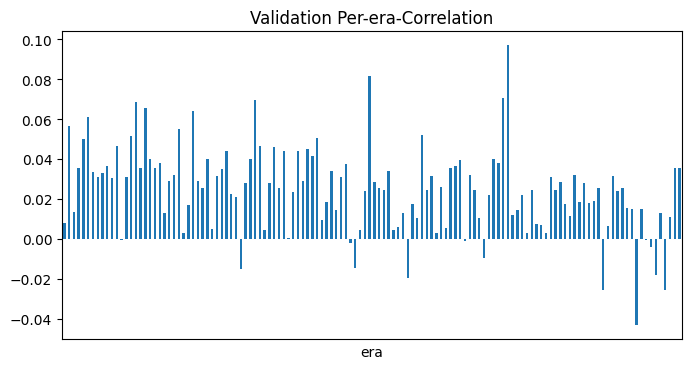

In [27]:
per_era_corr.plot(kind = "bar" , title = "Validation Per-era-Correlation" , figsize = (8,4) , xticks = [] , legend = False)

<Axes: title={'center': 'Validation Per-era-mmc'}, xlabel='era'>

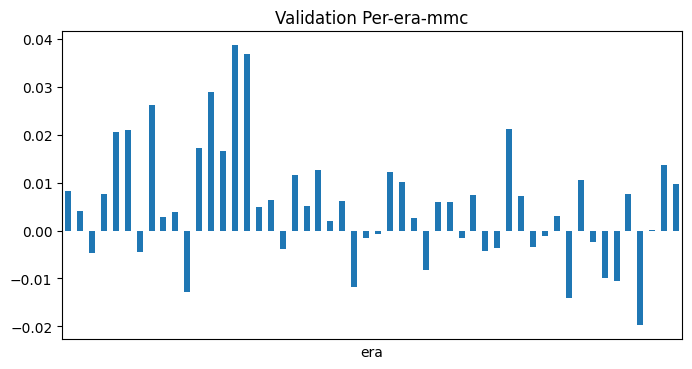

In [28]:
per_era_mmc.plot(kind = "bar" , title  = "Validation Per-era-mmc" , figsize = (8,4) , xticks = [] , legend = False)

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

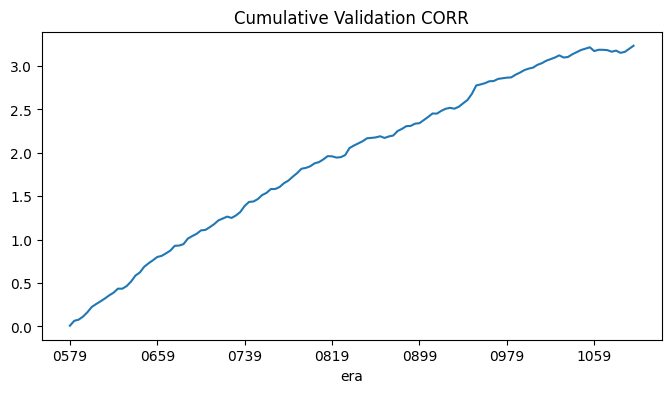

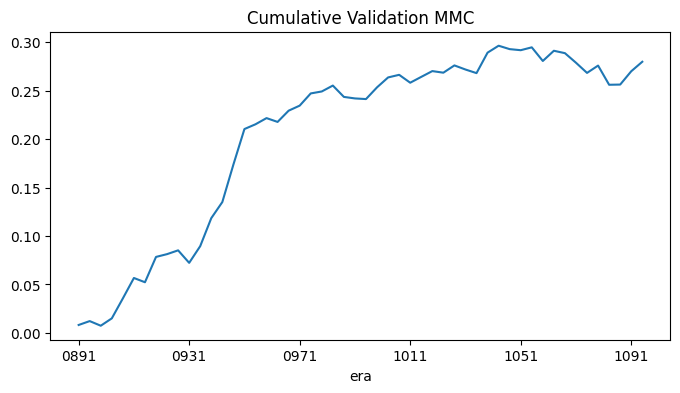

In [29]:
per_era_corr.cumsum().plot(
    title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)

per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

In [39]:
# some overall performance metrics
corr_mean = per_era_corr.mean()
corr_std  = per_era_corr.std(ddof = 0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods = 1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std  = per_era_mmc.std(ddof = 0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown  = (per_era_mmc.cumsum().expanding(min_periods = 1).max() - per_era_mmc.cumsum()).max()


pd.DataFrame({"mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]}, index = ["Corr","MMC"]).T

,Corr,MMC
mean,Prediction 0.024878 dtype: float64,Prediction 0.005379 dtype: float64
std,Prediction 0.021582 dtype: float64,Prediction 0.012016 dtype: float64
sharpe,Prediction 1.152716 dtype: float64,Prediction 0.447697 dtype: float64
max_drawdown,Prediction 0.063695 dtype: float64,Prediction 0.040279 dtype: float64


In [46]:
# downloading live dataset
napi.download_dataset(f'{dataset_version}/live_int8.parquet')

# load live predictions
live_features = pd.read_parquet(f"{dataset_version}/live_int8.parquet" , columns = feature_sets)

# generating live predictions
live_predictions = model.predict(live_features)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [50]:
pd.Series(live_predictions , index = live_features.index).to_frame("Prediction")

,Prediction
id,
n0025dfa934267ee,0.516894
n0034a0dc19a8a43,0.505614
n003700895a76e3a,0.507053
n003fa87ae5ae26e,0.508346
n0052ab88597e510,0.508294
...,...
nffc028ebd7b227f,0.523203
nffd7e0739051267,0.498629
nffe14427c1a9011,0.521525


In [35]:
# submission
def predict(live_features : pd.DataFrame) -> pd.DataFrame:
  live_predictions = model.predict(live_features)
  submission = pd.Series(live_predictions , index = live_features.index)
  return submission.to_frame("Predictions")

In [35]:
# serializing the predictions
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl" , "wb") as f:
  f.write(p)